# Сверточные нейронные сети 2 (ноутбук)

> Узнаем продвинутые подходы, которые улучшают качество и обучение сверточных нейронных сетей.

## План ноутбука:

 1. Регуляризация нейронных сетей
 1. Нормализация в нейронных сетях
 1. Инициализация параметров в слоях
 1. Аугментация данных для нейронных сетей
 1. Практика!

## Регуляризация

### Dropout

![](dropout.png)
https://images3.russianblogs.com/692/bb/bb00c7b2f22b7222d80ef9748e73380c.png
 - Определим как отдельный слой $d(x)$
 - Без параметров
 - Один гиперпараметр $p$ задает поведение
 - На этапе обучения:
     $$d(x) = \dfrac{1}{p}x * m$$
 ($m$ - вектор такого же размера как и $x$, из 0 и 1, вероятность получить 1 равна $p$, вероятность получить 0 равна $1 - p$)
 - Деление на $p$ - для сохранения суммарного масштаба входов
 - На этапе применения:
     $$d(x) = x$$
     
Возможная интерпретация: обучаем всевозможные архитектуры нейронных сетей, которые получаются из исходной выкидыванием отдельных нейронов, у этих архитектур общие веса, на этапе применения (с натяжечкой) усредняем прогнозы всех этих отдельных архитектур нейронных сетей.

## Нормализация

### Covariate shift and Domain shift

![](covariate_shift.png)
https://www.researchgate.net/profile/Patrick-Glauner/publication/322568228/figure/fig1/AS:583987370143745@1516244847412/Example-of-covariate-shift-training-and-test-data-having-different-distributions.png

### Internal covariate shift

 - В нейронных сетях каждый слой обучается на выходах предыдущих слоев
 - Если слой в начале сильно поменялся, то все следующие слои надо переделывать почти с нуля
 
Идея как с этим бороться: преобразовать выход слоя, чтобы он гарантированно имел фиксированное распределение.

## Batch Normalization

 - Определим как отдельный слой $\text{bn}(x)$
 - Вычисляется для текущего батча:
     - Оцениваем среднее и дисперсию каждой компоненты входного вектора
         $$\mu_B = \dfrac{1}{n}\sum\limits_{i=1}^{n}B_i$$
         $$\sigma^2_B = \dfrac{1}{n}\sum\limits_{i=1}^{n}(B_i - \mu_B)^2$$

In [1]:
import torch

In [2]:
batch = torch.rand((5, 3))

batch

tensor([[0.6373, 0.0830, 0.4993],
        [0.1414, 0.1024, 0.9346],
        [0.2280, 0.6351, 0.2438],
        [0.4181, 0.9635, 0.6219],
        [0.1901, 0.4597, 0.7624]])

In [3]:
mu = batch.mean(0)

mu

tensor([0.3230, 0.4487, 0.6124])

In [4]:
batch - mu

tensor([[ 0.3143, -0.3658, -0.1131],
        [-0.1816, -0.3463,  0.3222],
        [-0.0950,  0.1864, -0.3687],
        [ 0.0951,  0.5147,  0.0095],
        [-0.1329,  0.0110,  0.1500]])

In [5]:
(batch - mu).square()

tensor([[9.8778e-02, 1.3378e-01, 1.2792e-02],
        [3.2963e-02, 1.1995e-01, 1.0383e-01],
        [9.0241e-03, 3.4748e-02, 1.3591e-01],
        [9.0501e-03, 2.6495e-01, 8.9882e-05],
        [1.7654e-02, 1.1996e-04, 2.2513e-02]])

In [6]:
sigma = (batch - mu).square().mean(0)

sigma

tensor([0.0335, 0.1107, 0.0550])

In [7]:
def get_mean_std(x):
    mean = x.mean(0)
    return mean, (x - mean).square().mean(0)

In [8]:
get_mean_std(batch)

(tensor([0.3230, 0.4487, 0.6124]), tensor([0.0335, 0.1107, 0.0550]))

 - Теперь отмасштабируем все выходы:
     $$\hat{B}_i = \dfrac{B_i - \mu_B}{\sqrt{\sigma^2_B + \varepsilon}}$$
 - Зададим нужные (обучаемые) среднее и дисперсию:
     $$\text{bn}(B) = \hat{B} * \gamma + \beta$$
 - Размерность $\gamma$ и $\beta$ равна размерности входных векторов

In [9]:
batch - mu

tensor([[ 0.3143, -0.3658, -0.1131],
        [-0.1816, -0.3463,  0.3222],
        [-0.0950,  0.1864, -0.3687],
        [ 0.0951,  0.5147,  0.0095],
        [-0.1329,  0.0110,  0.1500]])

In [10]:
(sigma + 1e-8).sqrt()

tensor([0.1830, 0.3327, 0.2346])

In [11]:
batch_hat = (batch - mu) / (sigma + 1e-8).sqrt()

batch_hat  # mean = 0, std = 1

tensor([[ 1.7173, -1.0993, -0.4822],
        [-0.9920, -1.0409,  1.3737],
        [-0.5191,  0.5602, -1.5716],
        [ 0.5198,  1.5470,  0.0404],
        [-0.7260,  0.0329,  0.6396]])

In [12]:
get_mean_std(batch_hat)

(tensor([ 0.0000e+00, -2.3842e-08,  2.0862e-07]),
 tensor([1.0000, 1.0000, 1.0000]))

In [13]:
gamma = torch.ones(3)  # (1, 1, 1)
beta = torch.zeros(3) - 0.5  # (-0.5, -0.5, -0.5)
bn_output = batch_hat * gamma + beta

bn_output

tensor([[ 1.2173, -1.5993, -0.9822],
        [-1.4920, -1.5409,  0.8737],
        [-1.0191,  0.0602, -2.0716],
        [ 0.0198,  1.0470, -0.4596],
        [-1.2260, -0.4671,  0.1396]])

In [14]:
get_mean_std(bn_output)

(tensor([-0.5000, -0.5000, -0.5000]), tensor([1.0000, 1.0000, 1.0000]))

 - Во время применения нейронной сети все вычисления те же самые, но не вычисляем $\mu_B$ и $\sigma^2_B$, а используем их средние значения по всем батчам во время обучения
 - Вставляем `Batch Normalization` между полносвязным или сверточным слоем и нелинейностью
 - Позволяет увеличить длину шага в градиентном спуске
 
 ![](bn1.png)
 https://arxiv.org/pdf/1805.11604.pdf
 
 Добавим шум после батч нормализации, сильно хуже не стало, всё равно лучше, чем без батч нормализации, причем значительно.
 ![](bn2.png)
 
 Зато функционал ошибки становится сильно более гладким, более простая оптимизация.
 ![](bn3.png)

### Нормализация входных данных

Хорошая практика в глубинном обучении - нормализовать входные данные.

In [15]:
import numpy as np

from torchvision.datasets import MNIST
import torchvision.transforms as T

In [16]:
mnist_train = MNIST('/home/jupyter/mnt/datasets/mnist', transform=T.ToTensor())

In [17]:
mnist_train.data.shape

torch.Size([60000, 28, 28])

In [18]:
mean = mnist_train.data.to(torch.float32).mean().item() / 255

mean

0.13066047219669116

In [19]:
std = mnist_train.data.to(torch.float32).std().item() / 255

std

0.30810780244715075

In [20]:
normalize = T.Normalize(mean=(mean), std=(std))

In [21]:
mnist_train[0][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [22]:
normalized_image = normalize(mnist_train[0][0])

In [23]:
normalized_image

tensor([[[-0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
          -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
          -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
          -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241],
         [-0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
          -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
          -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
          -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241],
         [-0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
          -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
          -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
          -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241],
         [-0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
          -0.4241, -0.4241, -0.4241, -0.4241, -0

In [24]:
normalized_image.mean()

tensor(0.0228)

In [25]:
normalized_image.std()

tensor(1.0144)

In [26]:
normalize(mnist_train.data.to(torch.float32) / 255).mean()

tensor(2.9397e-08)

In [27]:
normalize(mnist_train.data.to(torch.float32) / 255).std()

tensor(1.0000)

## Инициализация параметров в слоях

 - Не должно быть симметрично
 - Плохо инициализировать одним и тем же числом
 - Хороший вариант:
     $$w_i \sim \dfrac{2}{\sqrt{n}}\mathcal{N}(0, 1)$$
 (где $n$ - число входов)
 - Пытаемся сделать одинаковый масштаб у всех выходов 

## Аугментация данных

![](augmentation1.jpeg)

https://pytorch.org/vision/stable/transforms.html

https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py

## Практическая часть с применением клевых штук

In [28]:
from torchvision.datasets import CIFAR10  # https://www.cs.toronto.edu/~kriz/cifar.html

![](cifar10.png)

In [29]:
dataset_train = CIFAR10('/home/jupyter/mnt/datasets/cifar10', train=True)

In [30]:
dataset_train[0]

(<PIL.Image.Image image mode=RGB size=32x32>, 6)

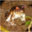

In [31]:
dataset_train[0][0]

In [32]:
import matplotlib.pyplot as plt

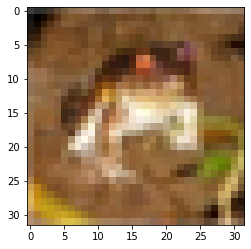

In [33]:
plt.imshow(dataset_train[0][0])
plt.show()

In [34]:
img_matrix = np.array(dataset_train[0][0]) / 255

img_matrix.shape

(32, 32, 3)

In [35]:
dataset_train = CIFAR10('/home/jupyter/mnt/datasets/cifar10', train=True, transform=T.ToTensor())

In [36]:
dataset_train.data.shape

(50000, 32, 32, 3)

In [37]:
means = (dataset_train.data / 255).mean(axis=(0, 1, 2))

means

array([0.49139968, 0.48215841, 0.44653091])

In [38]:
stds = (dataset_train.data / 255).std(axis=(0, 1, 2))

stds

array([0.24703223, 0.24348513, 0.26158784])

In [39]:
#!g1.1
import torchvision.transforms as T

transforms = T.Compose(
    [
        T.ToTensor(),
        T.Normalize(mean=means, std=stds)
    ]
)

In [40]:
#!g1.1
from torch.utils.data import DataLoader


train_dataset = CIFAR10('/home/jupyter/mnt/datasets/cifar10', train=True, transform=transforms)
valid_dataset = CIFAR10('/home/jupyter/mnt/datasets/cifar10', train=False, transform=transforms)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)

In [41]:
#!g1.1
from tqdm import tqdm


def train(model) -> float:
    model.train()

    train_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(train_loader, desc='Train'):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        train_loss += loss.item()

        loss.backward()

        optimizer.step()
        
        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    train_loss /= len(train_loader)
    accuracy = correct / total

    return train_loss, accuracy

In [42]:
#!g1.1
@torch.inference_mode()
def evaluate(model, loader) -> tuple[float, float]:
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        x, y = x.to(device), y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy

In [43]:
#!g1.1
from IPython.display import clear_output

def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    train_accuracy: list[float],
    valid_accuracy: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')
    
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()

In [44]:
#!g1.1
def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model)
        valid_loss, valid_accuracy = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )

In [45]:
#!g1.1
import torch.nn as nn
from torch.optim import Adam

In [46]:
#!g1.1
class FirstModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),  # 32 x 32 x 16
            nn.ReLU(),

            nn.MaxPool2d(2),  # 16 x 16 x 16

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),  # 16 x 16 x 32
            nn.ReLU(),

            nn.MaxPool2d(2),  # 8 x 8 x 32

            nn.Flatten(),

            nn.Linear(8 * 8 * 32, 1024),
            nn.ReLU(),
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)

In [47]:
#!g1.1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
print(torch.cuda.get_device_name())

loss_fn = nn.CrossEntropyLoss()

cuda:0
Tesla V100-SXM2-32GB


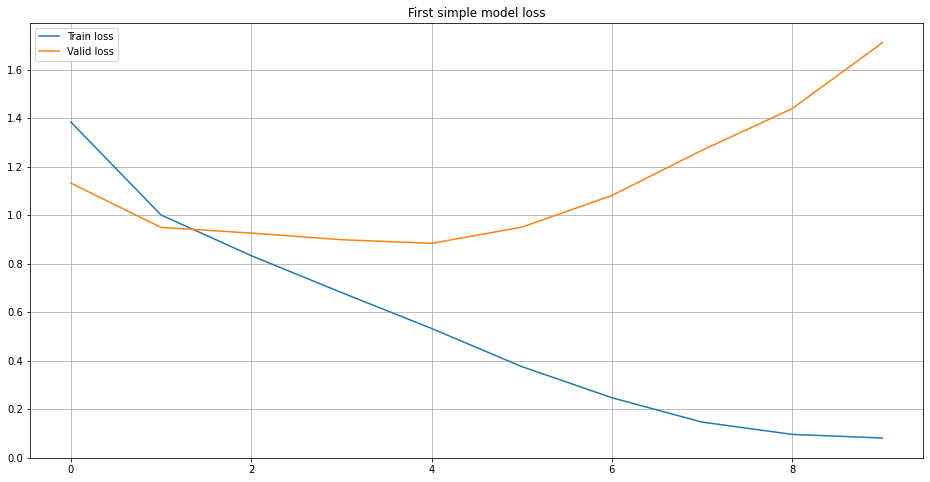

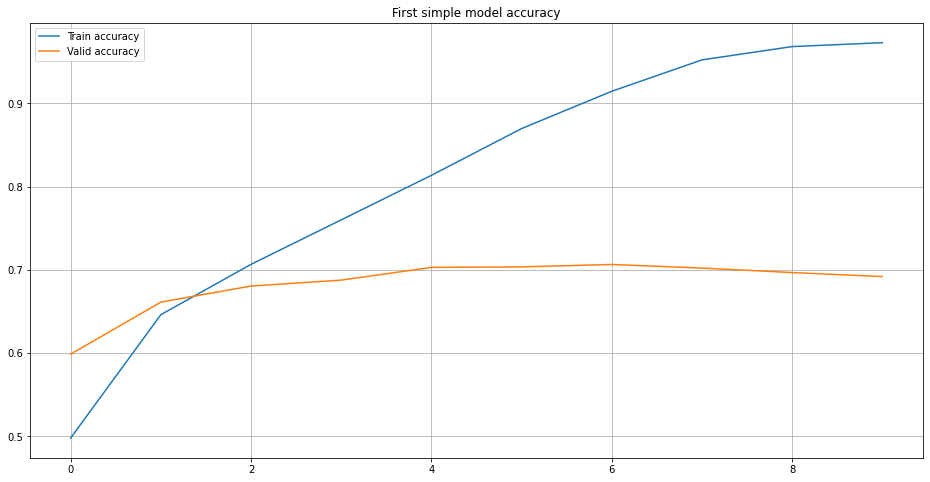

In [48]:
#!g1.1
model = FirstModel().to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

whole_train_valid_cycle(model, 10, 'First simple model')

In [49]:
#!g1.1
class SecondModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),  # 32 x 32 x 32
            nn.ReLU(),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),  # 32 x 32 x 32
            nn.ReLU(),

            nn.MaxPool2d(2),  # 16 x 16 x 32

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),  # 16 x 16 x 64
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),  # 16 x 16 x 64
            nn.ReLU(),

            nn.MaxPool2d(2),  # 8 x 8 x 32
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),  # 8 x 8 x 128
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),  # 8 x 8 x 128
            nn.ReLU(),

            nn.MaxPool2d(2),  # 4 x 4 x 128

            nn.Flatten(),

            nn.Linear(4 * 4 * 128, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        return self.net(x)

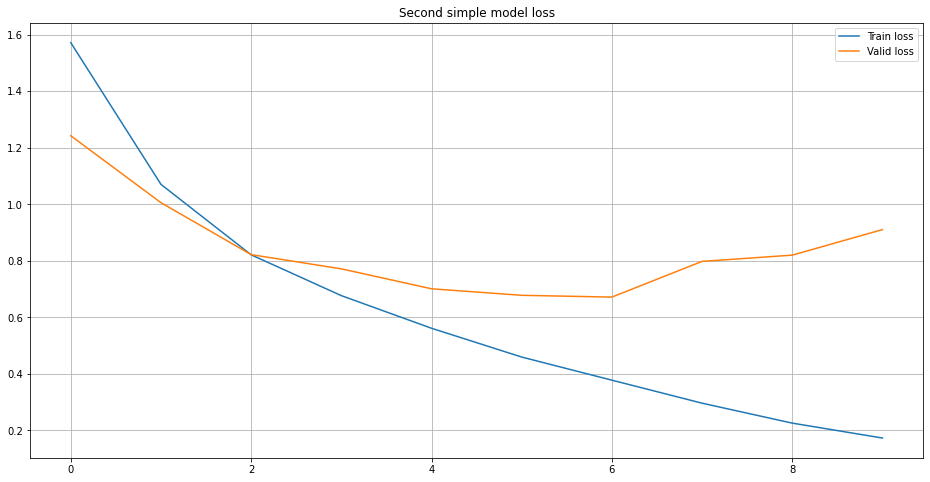

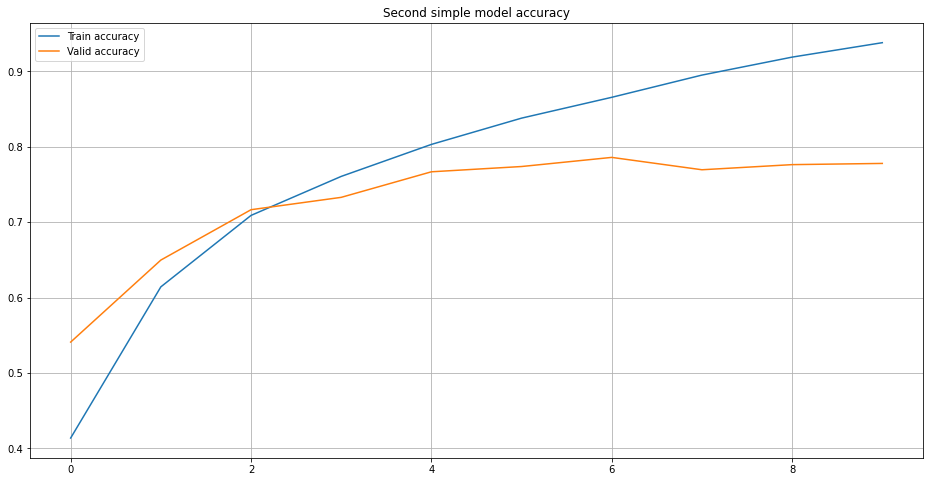

In [50]:
#!g1.1
model = SecondModel().to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

whole_train_valid_cycle(model, 10, 'Second simple model')

In [51]:
#!g1.1
class ThirdModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),  # 32 x 32 x 32
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),  # 32 x 32 x 32
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.MaxPool2d(2),  # 16 x 16 x 32

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),  # 16 x 16 x 64
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),  # 16 x 16 x 64
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2),  # 8 x 8 x 32
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),  # 8 x 8 x 128
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),  # 8 x 8 x 128
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.MaxPool2d(2),  # 4 x 4 x 128

            nn.Flatten(),

            nn.Linear(4 * 4 * 128, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        return self.net(x)

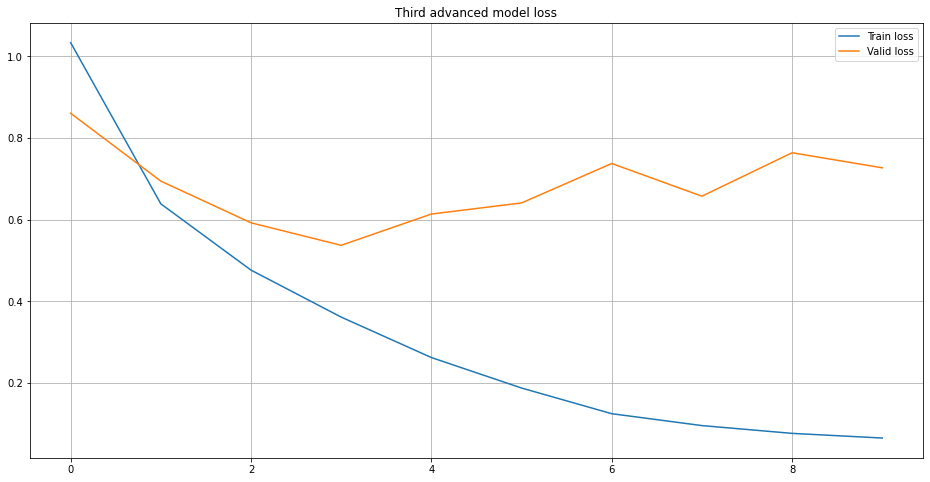

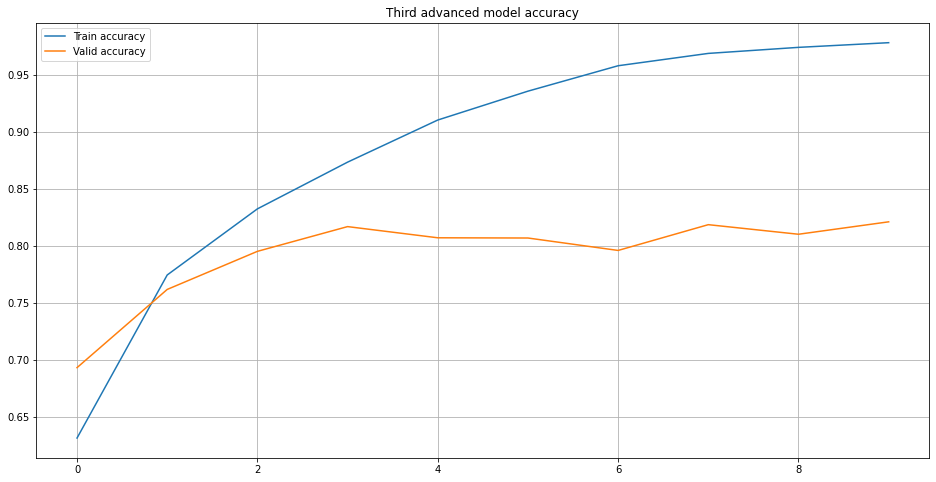

In [52]:
#!g1.1
model = ThirdModel().to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

whole_train_valid_cycle(model, 10, 'Third advanced model')

In [53]:
#!g1.1
class FourthModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),  # 32 x 32 x 32
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),  # 32 x 32 x 32
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.MaxPool2d(2),  # 16 x 16 x 32
            nn.Dropout2d(p=0.2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),  # 16 x 16 x 64
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),  # 16 x 16 x 64
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2),  # 8 x 8 x 32
            nn.Dropout2d(p=0.2),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),  # 8 x 8 x 128
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),  # 8 x 8 x 128
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.MaxPool2d(2),  # 4 x 4 x 128
            nn.Dropout2d(p=0.2),

            nn.Flatten(),

            nn.Linear(4 * 4 * 128, 512),
            nn.BatchNorm1d(512),
            nn.Dropout(p=0.3),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        return self.net(x)

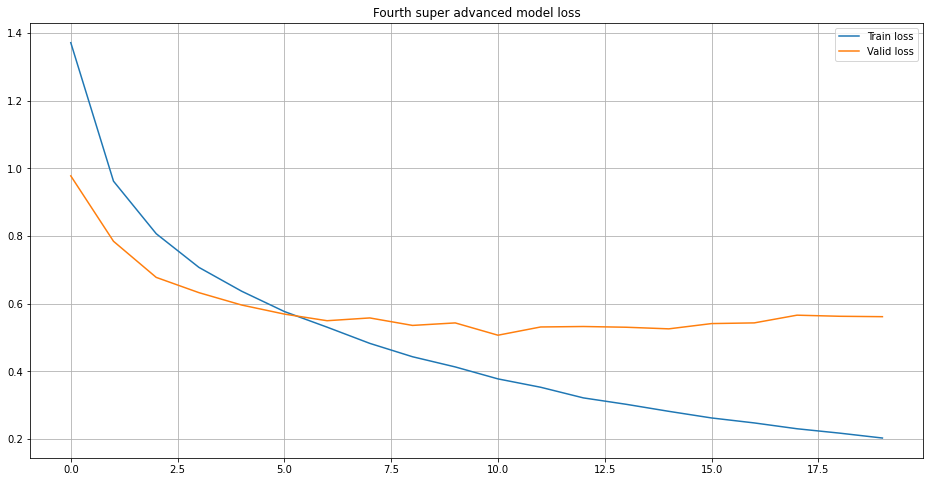

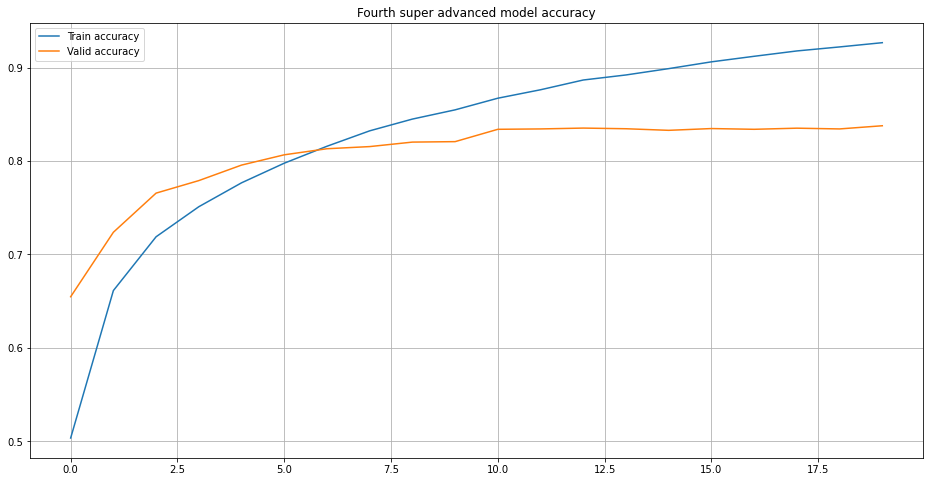

In [54]:
#!g1.1
model = FourthModel().to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

whole_train_valid_cycle(model, 20, 'Fourth super advanced model')

In [55]:
#!g1.1
train_transforms = T.Compose(
    [
        T.RandomResizedCrop(size=32, scale=(0.8, 1.1)),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomAdjustSharpness(sharpness_factor=2),
        T.ToTensor(),
        T.Normalize(mean=means, std=stds)
    ]
)

test_transforms = T.Compose(
    [
        T.ToTensor(),
        T.Normalize(mean=means, std=stds)
    ]
)

train_dataset = CIFAR10('/home/jupyter/mnt/datasets/cifar10', train=True, transform=train_transforms)
valid_dataset = CIFAR10('/home/jupyter/mnt/datasets/cifar10', train=False, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)

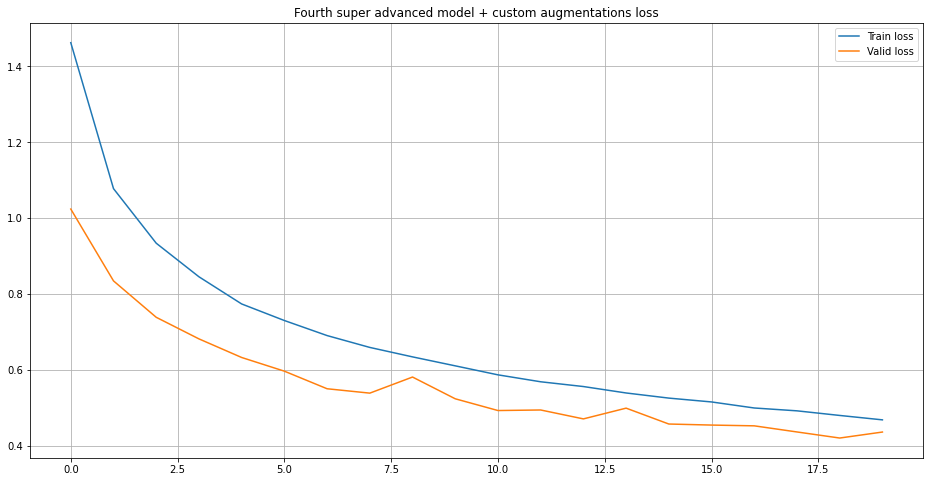

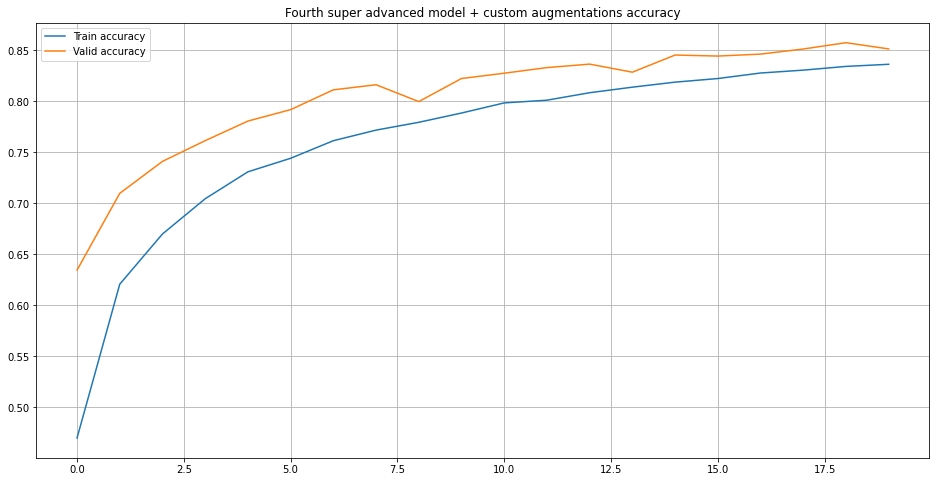

In [56]:
#!g1.1
model = FourthModel().to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

whole_train_valid_cycle(model, 20, 'Fourth super advanced model + custom augmentations')

In [57]:
#!g1.1
train_transforms = T.Compose(
    [
        T.RandAugment(),
        T.ToTensor(),
        T.Normalize(mean=means, std=stds)
    ]
)

test_transforms = T.Compose(
    [
        T.ToTensor(),
        T.Normalize(mean=means, std=stds)
    ]
)

train_dataset = CIFAR10('/home/jupyter/mnt/datasets/cifar10', train=True, transform=train_transforms)
valid_dataset = CIFAR10('/home/jupyter/mnt/datasets/cifar10', train=False, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)

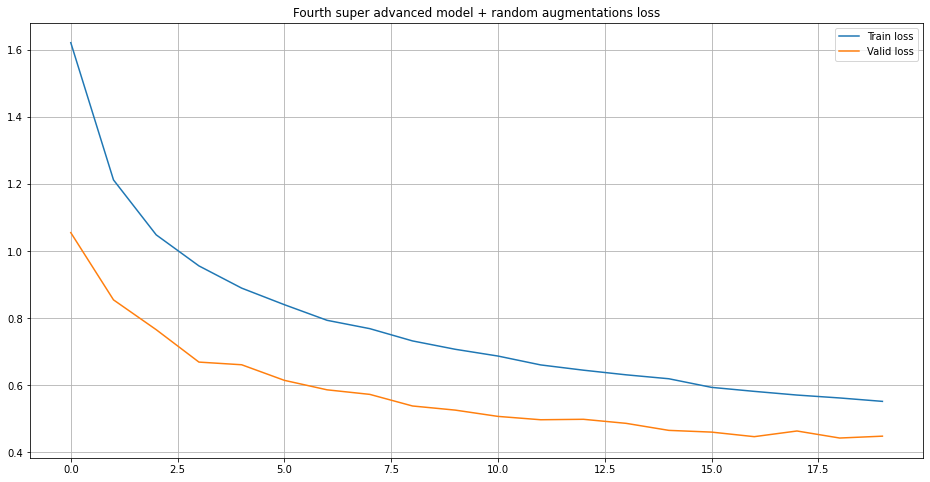

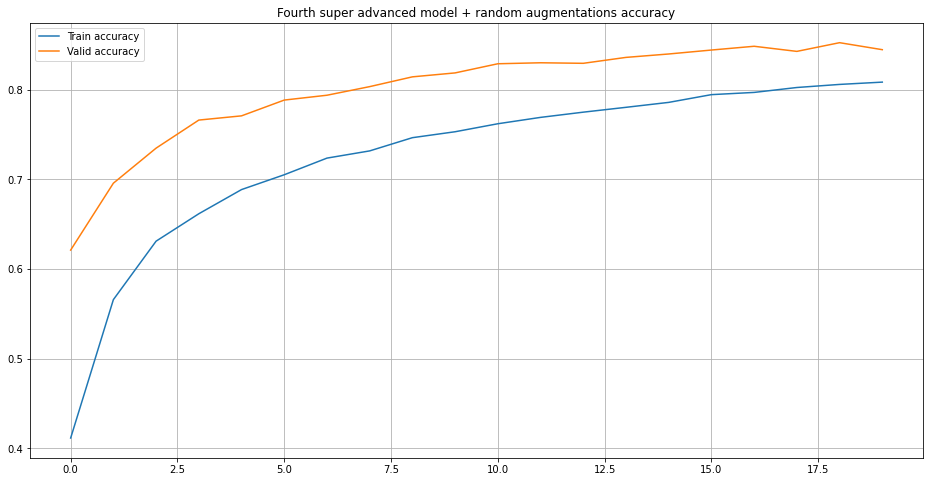

In [58]:
#!g1.1
model = FourthModel().to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

whole_train_valid_cycle(model, 20, 'Fourth super advanced model + random augmentations')

In [59]:
#!g1.1
train_transforms = T.Compose(
    [
        T.AutoAugment(T.AutoAugmentPolicy.CIFAR10),
        T.ToTensor(),
        T.Normalize(mean=means, std=stds)
    ]
)

test_transforms = T.Compose(
    [
        T.ToTensor(),
        T.Normalize(mean=means, std=stds)
    ]
)

train_dataset = CIFAR10('/home/jupyter/mnt/datasets/cifar10', train=True, transform=train_transforms)
valid_dataset = CIFAR10('/home/jupyter/mnt/datasets/cifar10', train=False, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)

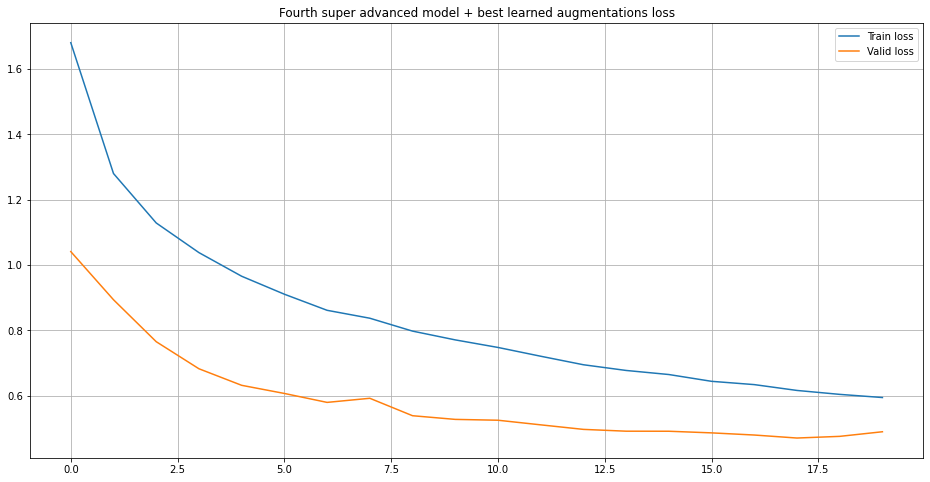

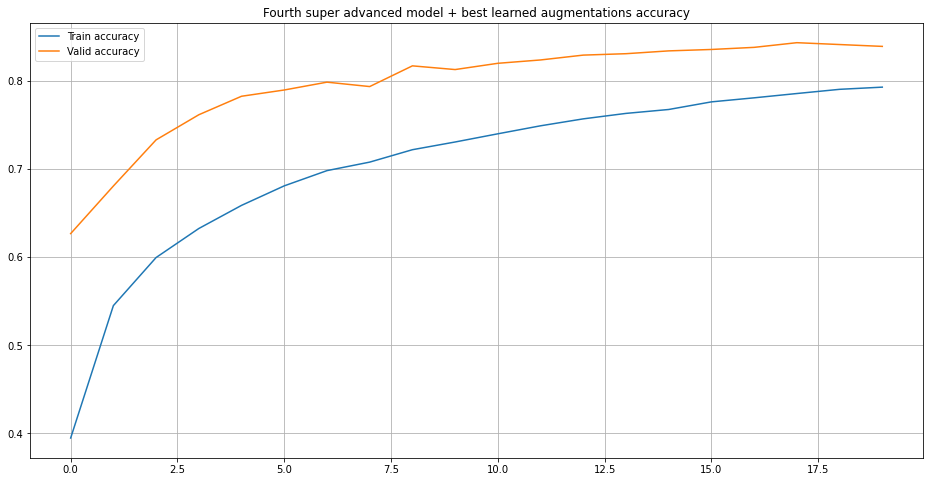

In [60]:
#!g1.1
model = FourthModel().to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

whole_train_valid_cycle(model, 20, 'Fourth super advanced model + best learned augmentations')

In [61]:
#!g1.1

#https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

def whole_train_valid_cycle_with_scheduler(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model)
        valid_loss, valid_accuracy = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )

        scheduler.step()

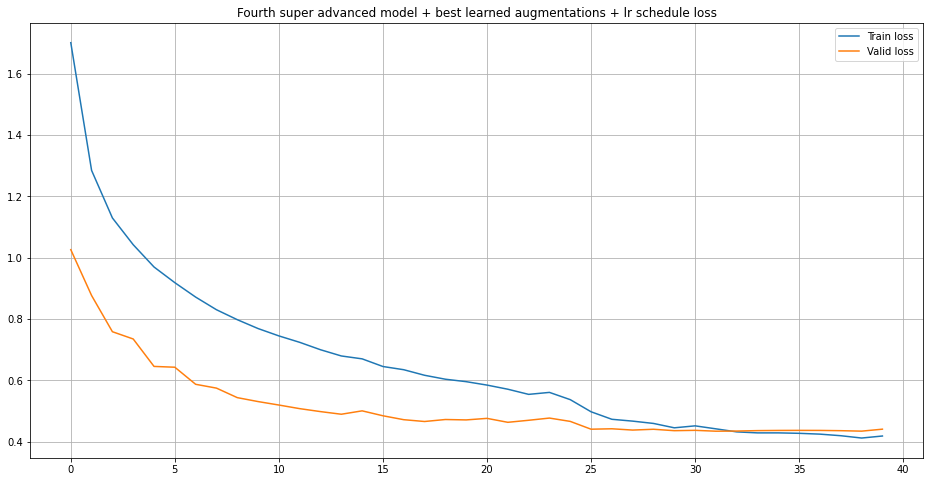

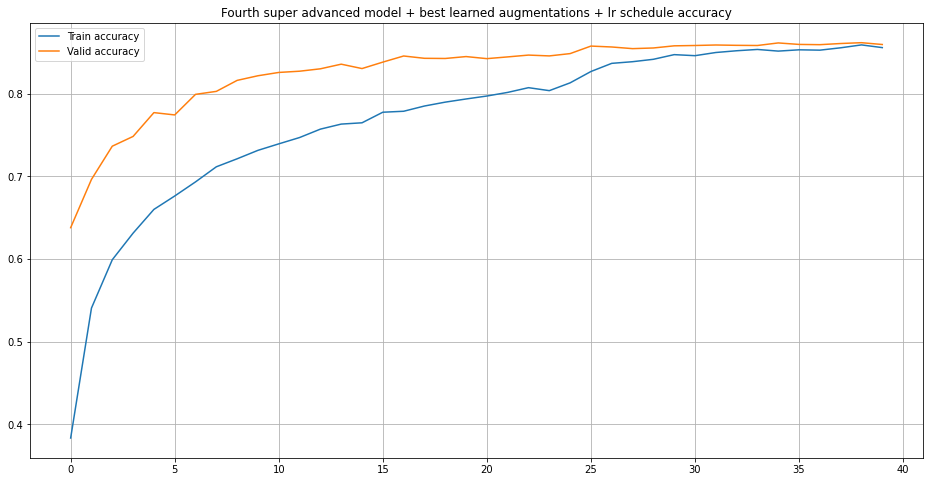

In [63]:
#!g1.1
from torch.optim.lr_scheduler import StepLR

model = FourthModel().to(device)

optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=25)

whole_train_valid_cycle_with_scheduler(model, 40, 'Fourth super advanced model + best learned augmentations + lr schedule')